In [22]:
#import all necessary modules
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator,image 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

#Import supplementary visualization code visuals.py
import visuals as vs
# Display all visuals inline
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [23]:

# Load the Banknote Authentication dataset
data = pd.read_csv("Dataset\preprocessed_data.csv")
display(data.head(n=6))

classes = data['class']
features = data.drop('class', axis=1)

,variance,skewness,kurtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0
5,4.36840,9.6718,-3.9606,-3.16250,0


In [24]:
n_records = len(data)
n_fake_notes = len(data[data['class'] == 0])
n_real_notes = len(data[data['class'] == 1])
print ("Total number of records: {}".format(n_records))
print ("Total number of fake notes: {}".format(n_fake_notes))
print ("Total number of real notes: {}".format(n_real_notes))

missing_values = data.isnull().sum().sum()
if missing_values == 0:
    print ("\nThere are no missing values in the dataset")
else:
    print("\nThe dataset has {} missing values".format(missing_values))

Total number of records: 1372
Total number of fake notes: 762
Total number of real notes: 610

There are no missing values in the dataset


In [25]:
display(data.describe())

,variance,skewness,kurtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


### Looking for Skewedness in Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. We plot distributions of all continuous features to find if any skewedness is present in any of the features. We observe that all features are well distributed and do not have any such outlier values.

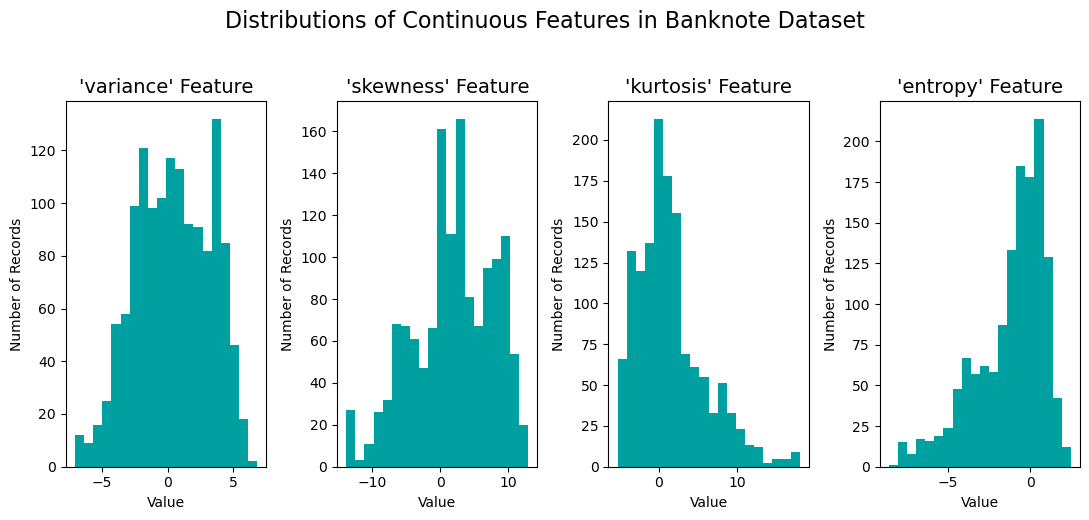

In [26]:
# feature plotting
vs.distribution(data)

### Identifying Predictive Power of Features
We create six classification scatter plots (using 2 of the 4 numerical attributes for each display), and use different colors for objects belonging to class 1 and class 0. This will give us an idea about which pair of features classify the dataset more strongly.

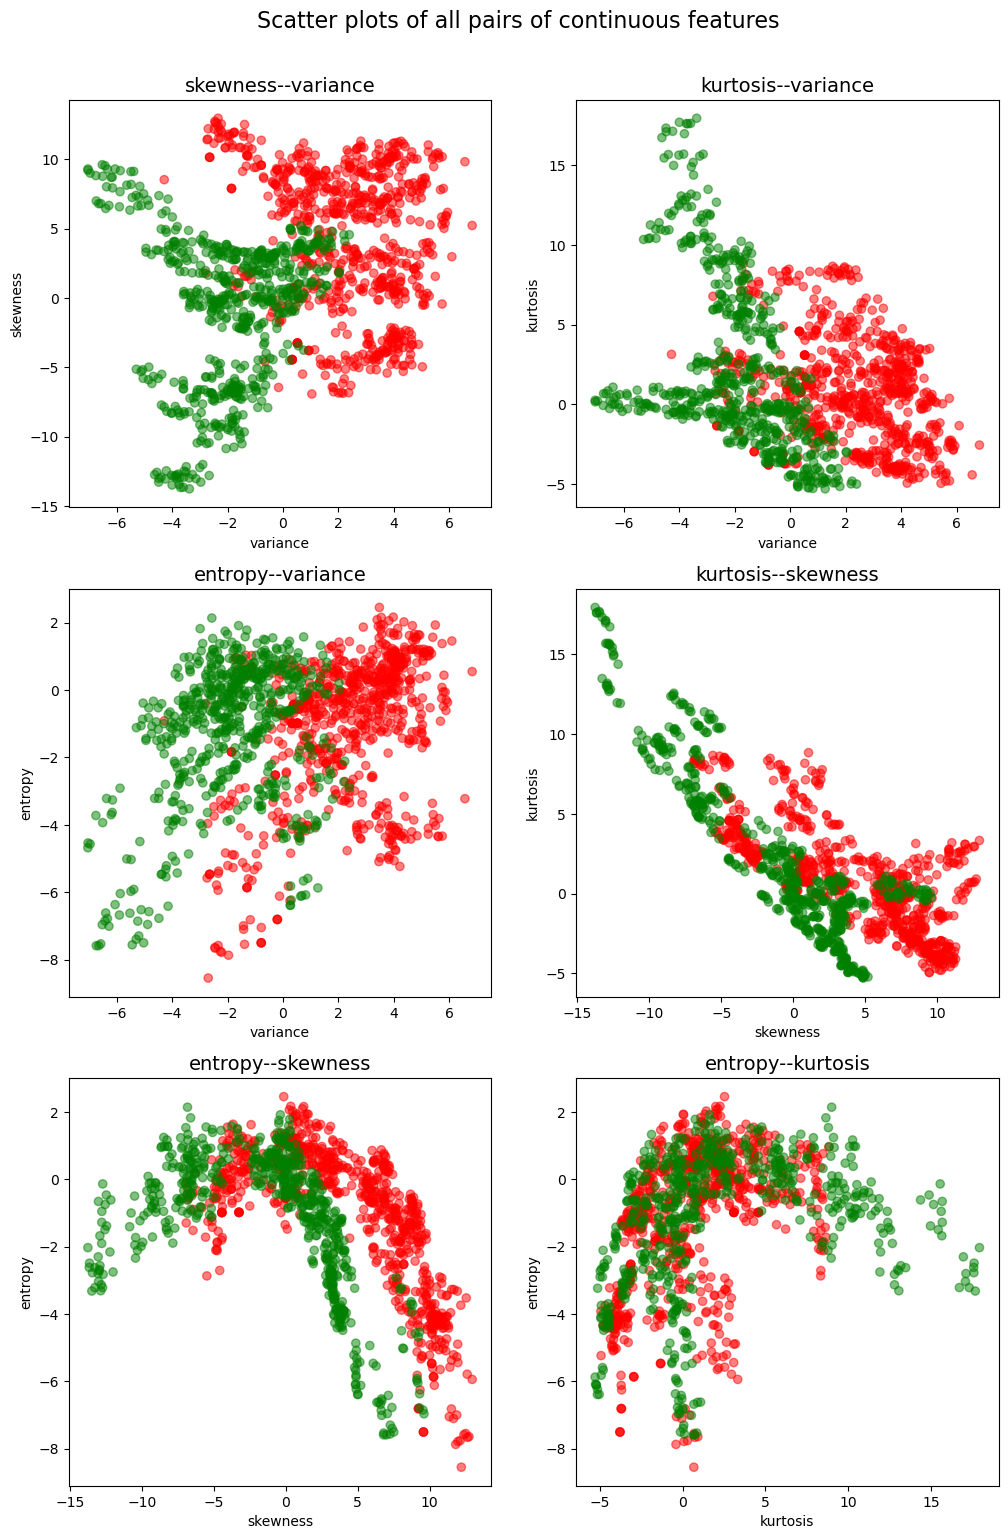

In [27]:
vs.scatter(data)

### Normalizing Numerical Features
 In this section, we want to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as 'variance' or 'skewedness' above); however, normalization ensures that each feature is treated equally when applying supervised learners. 

In [28]:
from sklearn.preprocessing import MinMaxScaler
numerical = ['variance', 'skewness', 'kurtosis', 'entropy']
scaler = MinMaxScaler()
features[numerical] = scaler.fit_transform(features[numerical])

display(features.head(n = 6))

,variance,skewness,kurtosis,entropy
0,0.769004,0.839643,0.106783,0.736628
1,0.835659,0.820982,0.121804,0.644326
2,0.786629,0.416648,0.310608,0.786951
3,0.757105,0.871699,0.054921,0.450440
4,0.531578,0.348662,0.424662,0.687362
5,0.822859,0.877275,0.057100,0.489711


### Shuffle and Split Data
Now that all numerical features have been normalized, we will now split the data (both features and their labels) into training and test sets. 60% of the data will be used for training and 40% for testing.

In [29]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'classes' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, classes, test_size = 0.4, random_state = 5)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 823 samples.
Testing set has 549 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a naive predictor, which is our benchmark model.

### Metrics and the Naive Predictor
We also require to define evaluation metrics that we can use to quantify the performance of our solution, as well as, the benchmark model. The metrics that we will use for our problem are accuracy and f-score. Accuracy is defined as the number of samples correctly classified to the total number of samples. This can be a good metric, but suppose, if it’s more detrimental for us if are not able to correctly classify a fake note, than a real one. Therefore, the model’s ability to recall all fake currency notes is more important than the model’s ability to make precise prediction. In this scenario, we can use, Fβ score with β = 2, as it weighs recall more than precision. The general form is: 
$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

We will compare the performance of our model with a naïve classifier, which classifies all banknotes as fake. The accuracy of this naïve classifier will be number of fake banknotes to the total number of notes in the data. Our model should perform far better than the naïve approach to be any worthy for intended use. Since, this naïve prediction model does not consider any information to substantiate its claim, it helps establish a benchmark for whether a model is performing well. That been said, using a naïve prediction would be pointless as will predict all notes counterfeit and would not identify any note as genuine.

In the code cell below, we calculate the evaluation metrics for the Naive Predictor benchmark model.

In [30]:
# Calculate Accuracy
accuracy = float(n_fake_notes)/n_records

# Calculate F-Score with beta = 2
precision = accuracy
recall = 1
beta = 2
fscore = (1 + beta ** 2) * precision * recall /(beta ** 2 * precision + recall)

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.5554, F-score: 0.8620]


### Supervised Learning Models
We have chosen the following supervised learning models to build the trained models:
- Support Vector Machines (SVM)
- Gradient Boosting, an ensemble method
- K-Nearest Neighbors (KNeighbors)

### Implementation: Create Training and Prediction Pipeline
To properly evaluate the performance of each model you've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In [31]:
# Import two metrics from sklearn - F1 score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import time

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    beta=2
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    # then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train,beta=beta)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test,beta=beta)
    
    # Compute Confusion Matrix
    results['conf_mat'] = confusion_matrix(y_test, predictions_test)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial Model Evaluation
In the code cell, we implement the following:
- Import the three supervised learning models that we have chosen.
- Initialize the three models and store them in 'clf_A', 'clf_B', and 'clf_C'.
- Calculate the number of records equal to 5%, 20%, and 100% of the training data.
- Store those values in 'samples_5', 'samples_20', and 'samples_100' respectively.

In [33]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from math import ceil
from time import time

# Initialize the three models
clf_A = KNeighborsClassifier(n_neighbors = 5)
clf_B = SVC(random_state = 5)
clf_C = GradientBoostingClassifier(random_state = 5)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_5 = int(X_train.shape[0] * 0.05)
samples_20 = int(X_train.shape[0] * 0.2)
samples_100 = X_train.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_5, samples_20, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

print ("\nTrain-Test Scores when trained on entire training set")
for key, value in results.items():
    print ("For {} Classifier, scores on training and test set are:".format(key))
    print ("Accuracy on Train set: {}".format(value[2]['acc_train']))
    print ("Accuracy on Test set: {}".format(value[2]['acc_test']))
    print ("F-score on Train set: {}".format(value[2]['f_train']))
    print ("F-score on Test set: {}".format(value[2]['f_test']))
    print ("Confusion Matrix for test set:\n {}".format(value[2]['conf_mat']))
# Run metrics visualization for the three supervised learning models chosen


KNeighborsClassifier trained on 41 samples.
KNeighborsClassifier trained on 164 samples.
KNeighborsClassifier trained on 823 samples.
SVC trained on 41 samples.
SVC trained on 164 samples.
SVC trained on 823 samples.
GradientBoostingClassifier trained on 41 samples.
GradientBoostingClassifier trained on 164 samples.
GradientBoostingClassifier trained on 823 samples.

Train-Test Scores when trained on entire training set
For KNeighborsClassifier Classifier, scores on training and test set are:
Accuracy on Train set: 1.0
Accuracy on Test set: 0.9981785063752276
F-score on Train set: 1.0
F-score on Test set: 0.999213217938631
Confusion Matrix for test set:
 [[294   1]
 [  0 254]]
For SVC Classifier, scores on training and test set are:
Accuracy on Train set: 1.0
Accuracy on Test set: 1.0
F-score on Train set: 1.0
F-score on Test set: 1.0
Confusion Matrix for test set:
 [[295   0]
 [  0 254]]
For GradientBoostingClassifier Classifier, scores on training and test set are:
Accuracy on Train 